In [430]:
# -*- coding: utf-8 -*-
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import rc
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_val_score
plt.rcParams['axes.unicode_minus'] = False

rc('font', family='AppleGothic')

## Load DataSet

In [431]:
train = pd.read_csv("./Kor_Train_교통사망사고정보(12.1~17.6).csv")
print(train.shape)
train.head()

(25037, 27)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993


In [432]:
test = pd.read_csv("./test_kor.csv")
print(test.shape)
test.head()

(50, 16)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차


## Explore

### 주야

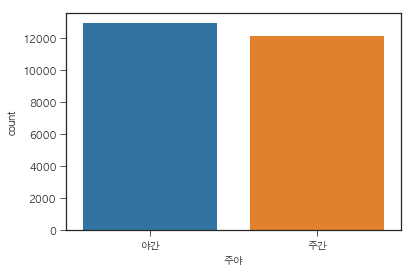

In [433]:
sns.countplot(data=train, x="주야")

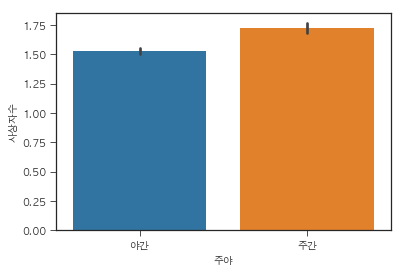

In [434]:
sns.barplot(data=train, x="주야", y="사상자수")

### 요일

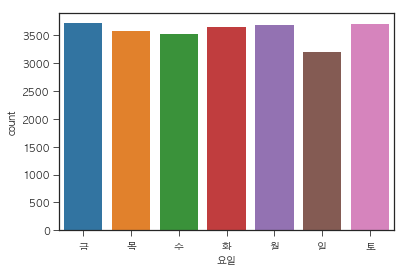

In [435]:
sns.countplot(data=train, x="요일")

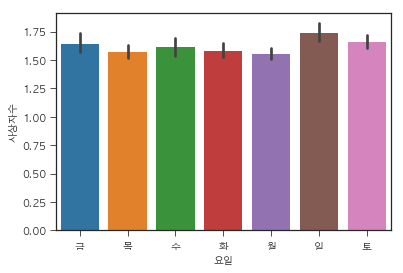

In [436]:
sns.barplot(data=train, x="요일", y="사상자수")

### 사고유형_대분류

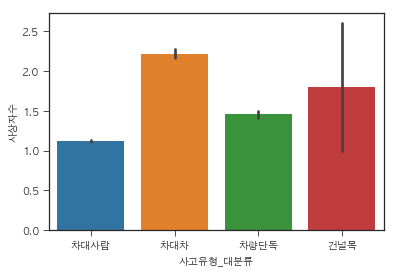

In [437]:
sns.barplot(data=train, x="사고유형_대분류", y="사상자수")

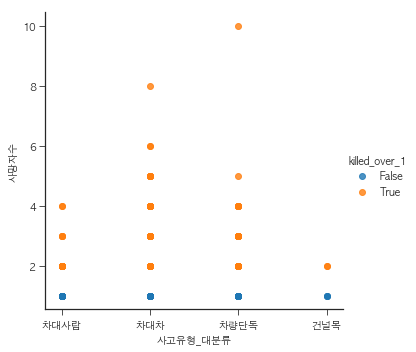

In [438]:
train["killed_over_1"] = train["사망자수"] > 1
sns.lmplot(data=train, x="사고유형_대분류", y="사망자수", hue="killed_over_1", fit_reg=False)

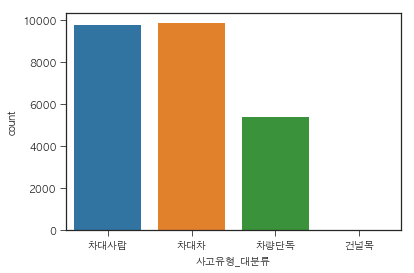

In [439]:
sns.countplot(data=train, x="사고유형_대분류")

In [440]:
train.loc[train["사고유형_대분류"] == "건널목"]

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,killed_over_1
6838,2015,2015102503,52,야간,일,1,1,0,0,0,...,건널목,화물차,소형,열차,열차,1120555,1770049,128.836211,35.919675,False
17114,2013,2013080614,26,주간,화,2,3,1,0,0,...,건널목,승용차,소형,열차,열차,962566,2010834,127.066622,38.088022,True
17728,2013,2013062122,38,야간,금,1,1,0,0,0,...,건널목,이륜차,소형,열차,열차,1156181,1761232,129.229212,35.835173,False
23811,2012,2012040618,17,야간,금,2,3,1,0,0,...,건널목,승용차,소형,열차,열차,950438,1775065,126.950294,35.971076,True
24895,2012,2012011123,22,야간,수,1,1,0,0,0,...,건널목,이륜차,중형,열차,열차,1143022,1688953,129.070827,35.185712,False


### 사고유형_중분류

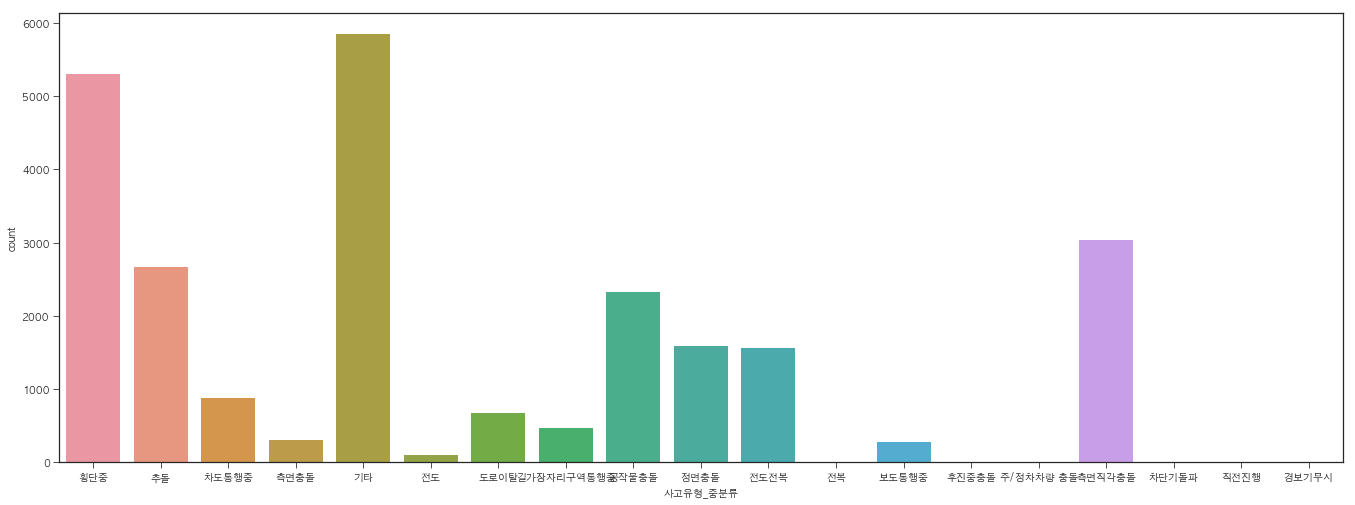

In [441]:

fig, ax = plt.subplots()
fig.set_size_inches(23, 8.27)  
sns.countplot(data=train, x="사고유형_중분류" )

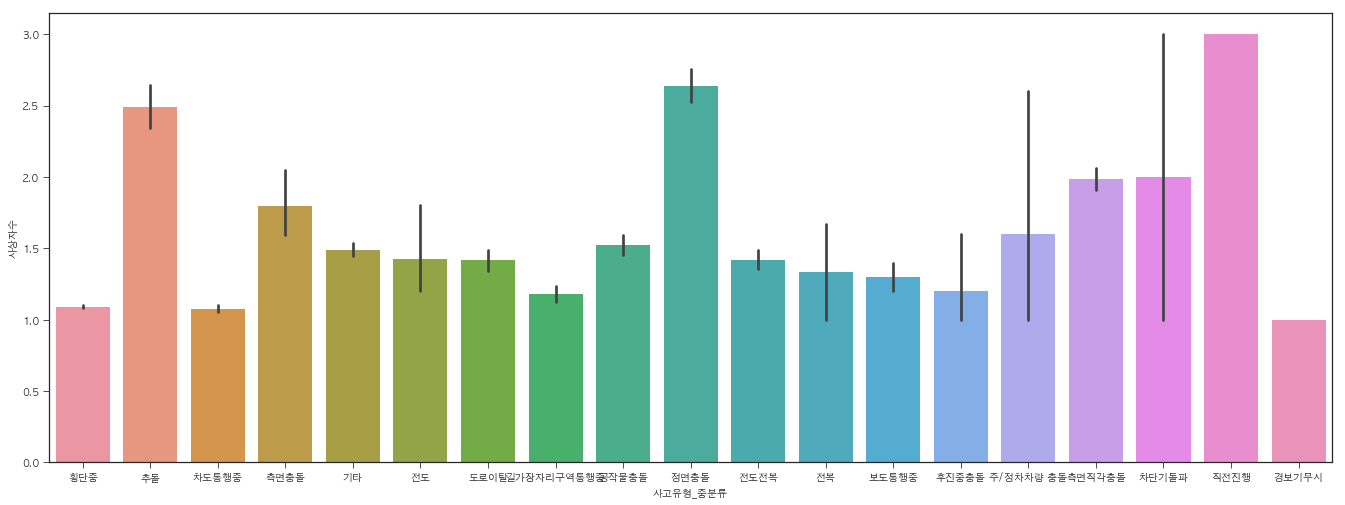

In [442]:
fig, ax = plt.subplots()
fig.set_size_inches(23, 8.27)  
sns.barplot(data=train, x="사고유형_중분류", y="사상자수")

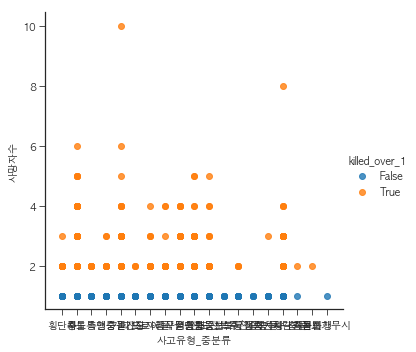

In [443]:
sns.lmplot(data=train, x="사고유형_중분류", y="사망자수", hue="killed_over_1", fit_reg=False)

### 법규위반

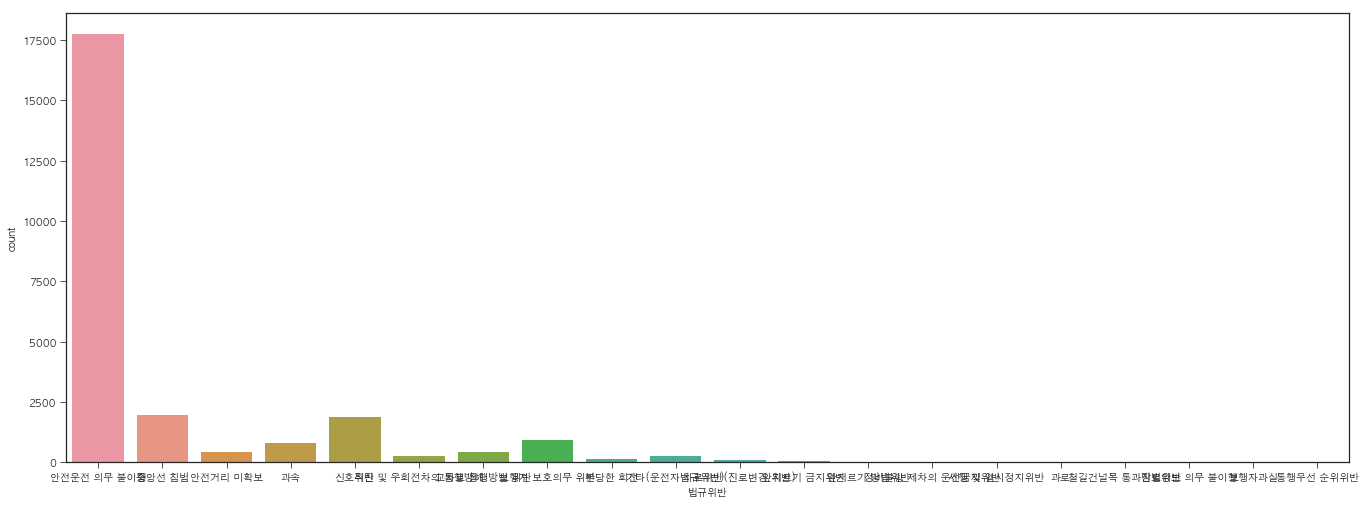

In [444]:
fig, ax = plt.subplots()
fig.set_size_inches(23, 8.27)  
sns.countplot(data=train, x="법규위반")

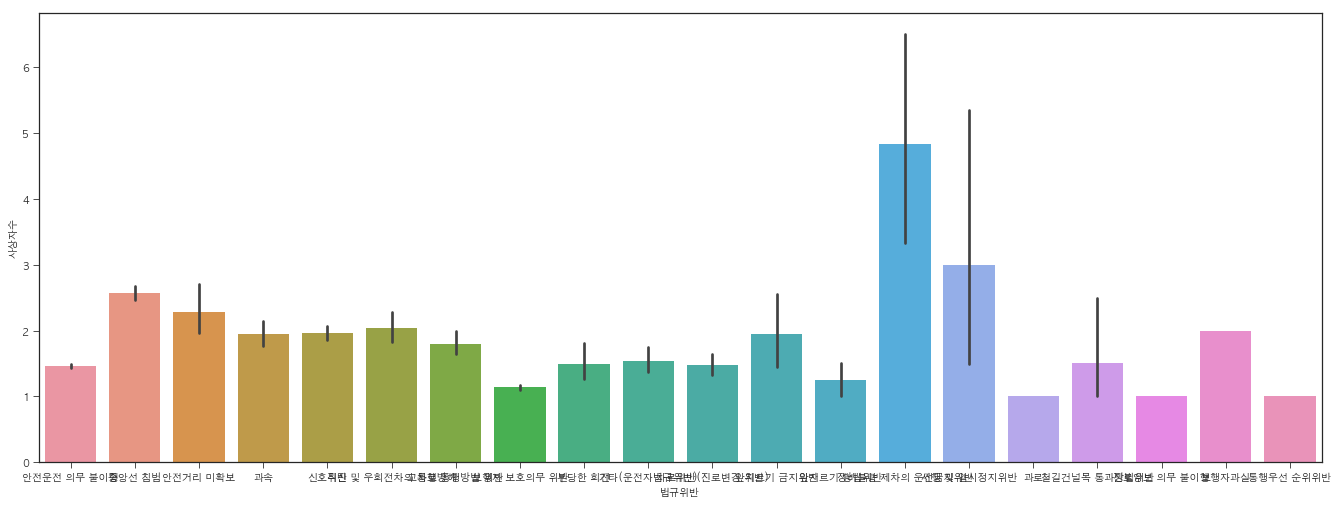

In [445]:
fig, ax = plt.subplots()
fig.set_size_inches(23, 8.27)  
sns.barplot(data=train, x="법규위반", y="사상자수")

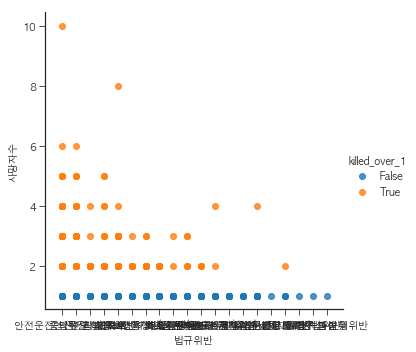

In [446]:
sns.lmplot(data=train, x="법규위반",  y="사망자수", hue="killed_over_1", fit_reg=False)

### 도로형태

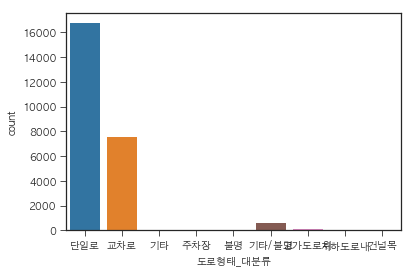

In [447]:
sns.countplot(data=train, x="도로형태_대분류")

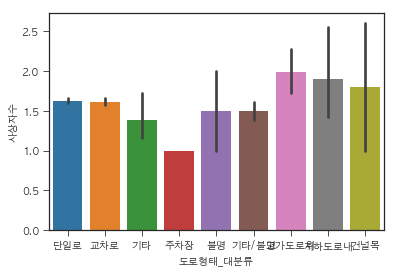

In [448]:
sns.barplot(data=train, x="도로형태_대분류", y="사상자수")

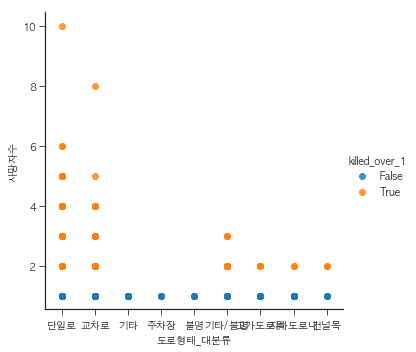

In [449]:
sns.lmplot(data=train, x="도로형태_대분류",  y="사망자수", hue="killed_over_1", fit_reg=False)

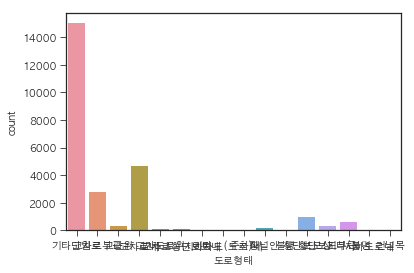

In [450]:
sns.countplot(data=train, x="도로형태")

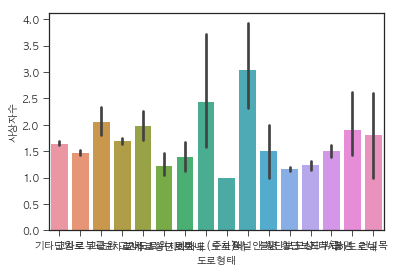

In [451]:
sns.barplot(data=train, x="도로형태", y="사상자수")

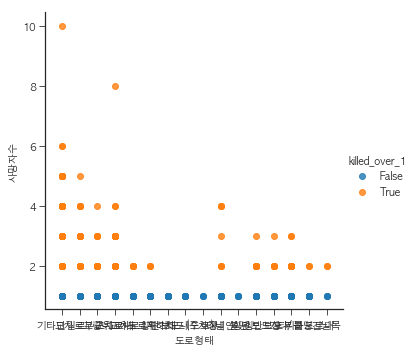

In [452]:
sns.lmplot(data=train, x="도로형태",  y="사망자수", hue="killed_over_1", fit_reg=False)

## 발생위치

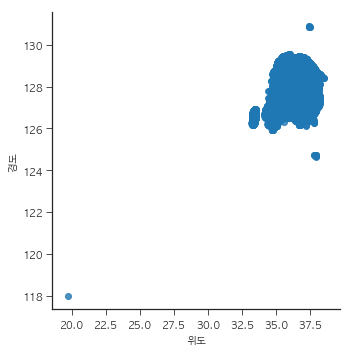

In [453]:
sns.lmplot(data=train, x="위도", y="경도", fit_reg=False)

In [454]:
data_removeOutlier = train.loc[train["위도"] > 20]

/Users/PJS/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


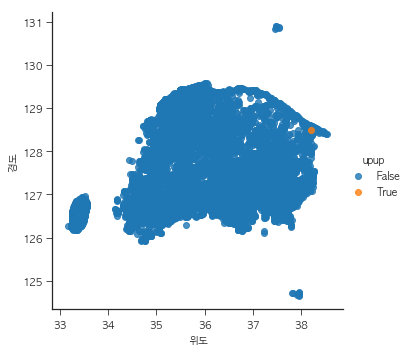

In [455]:
data_removeOutlier["upup"] = data_removeOutlier["사상자수"] > 90
sns.lmplot(data=data_removeOutlier, x="위도", y="경도", hue="upup", fit_reg=False)

In [456]:
train.loc[train["경도"] < 125]

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,killed_over_1
1972,2016,2016122220,55,야간,목,1,1,0,0,0,...,기타단일로,승용차,경형,보행자,보행자,0,0,117.992603,19.694477,False
2203,2016,2016120310,50,주간,토,1,1,0,0,0,...,기타단일로,불명,불명,없음,없음,755186,1984097,124.718517,37.823807,False
3038,2016,2016100123,30,야간,토,1,1,0,0,0,...,기타단일로,승용차,중형,보행자,보행자,756184,2000094,124.724437,37.968087,False
3548,2016,2016081902,25,야간,금,1,4,3,0,0,...,기타단일로,승용차,중형,없음,없음,754452,1985513,124.709706,37.836357,False
4525,2016,2016051714,5,주간,화,1,1,0,0,0,...,기타단일로,화물차,소형,농기계,농기계,752398,1997371,124.682322,37.942550,False
7941,2015,2015080309,55,주간,월,1,1,0,0,0,...,교차로내,승용차,중형,보행자,보행자,750342,1995365,124.659647,37.923929,False
17002,2013,2013081422,15,야간,수,1,1,0,0,0,...,기타/불명,화물차,소형,보행자,보행자,756245,2000071,124.733259,37.954716,False
20278,2012,2012120117,0,주간,토,1,1,0,0,0,...,기타단일로,화물차,소형,없음,없음,749673,2000195,124.650131,37.967075,False
21032,2012,2012101623,17,야간,화,1,3,1,1,0,...,기타단일로,승용차,중형,승용차,중형,750468,1999037,124.659806,37.957019,False
22401,2012,2012071315,10,주간,금,1,2,0,1,0,...,기타단일로,화물차,소형,승용차,중형,755096,2000166,124.712040,37.968442,False


In [457]:
train.loc[train["경도"] > 130]

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,killed_over_1
2969,2016,2016100620,11,야간,목,1,1,0,0,0,...,교차로부근,이륜차,사발이,없음,없음,1296967,1953740,130.860809,37.535188,False
13401,2014,2014052007,0,주간,화,1,1,0,0,0,...,기타단일로,이륜차,사발이,없음,없음,1298055,1954209,130.872144,37.541171,False
13493,2014,2014051314,43,주간,화,1,1,0,0,0,...,교차로부근,농기계,농기계,없음,없음,1295333,1946260,130.837930,37.470410,False
18325,2013,2013050906,15,주간,목,2,2,0,0,0,...,기타단일로,이륜차,사발이,없음,없음,1296237,1947378,130.849999,37.478176,True
22755,2012,2012061805,45,야간,월,1,1,0,0,0,...,기타단일로,화물차,소형,없음,없음,1300050,1947398,130.897725,37.479326,False
23566,2012,2012042302,0,야간,월,1,5,0,3,1,...,기타단일로,승용차,중형,없음,없음,1301128,1947627,130.905322,37.478836,False


## Preprocess

### 주야

In [458]:
train["주간"] = train["주야"] == "주간"
train["야간"] = train["주야"] == "야간"
print(train.shape)
train.head()

(25037, 30)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,killed_over_1,주간,야간
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,승용차,보행자,보행자,967633,1937456,127.134130,37.435704,False,False,True
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,승용차,승용차,승용차,966456,1696405,127.131220,35.262534,False,False,True
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,승용차,보행자,보행자,900057,1865697,126.379922,36.784142,False,False,True
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973,False,False,True
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993,False,True,False


In [459]:
test["주간"] = test["주야"] == "주간"
test["야간"] = test["주야"] == "야간"
print(test.shape)
test.head()

(50, 18)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류,주간,야간
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차,False,True
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자,False,True
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음,False,True
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차,False,True
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차,True,False


### 요일

In [460]:
train["day"] = train["요일"]
print(train.shape)
train.head()

(25037, 31)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,killed_over_1,주간,야간,day
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,보행자,보행자,967633,1937456,127.134130,37.435704,False,False,True,금
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,승용차,승용차,966456,1696405,127.131220,35.262534,False,False,True,금
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,보행자,보행자,900057,1865697,126.379922,36.784142,False,False,True,금
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,이륜차,이륜차,1095230,1764891,128.554945,35.875973,False,False,True,금
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,화물차,화물차,947576,1946355,126.906786,37.514993,False,True,False,금


In [461]:
test["day"] = test["요일"]
print(test.shape)
test.head()

(50, 19)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류,주간,야간,day
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차,False,True,금
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자,False,True,금
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음,False,True,월
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차,False,True,일
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차,True,False,목


In [462]:
train["mon"] = train["day"] == "월"
train["tue"] = train["day"] == "화"
train["wed"] = train["day"] == "수"
train["thu"] = train["day"] == "목"
train["fri"] = train["day"] == "금"
train["sat"] = train["day"] == "토"
train["sun"] = train["day"] == "일"
print(train.shape)
train.head()

(25037, 38)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,주간,야간,day,mon,tue,wed,thu,fri,sat,sun
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,False,True,금,False,False,False,False,True,False,False
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,True,False,금,False,False,False,False,True,False,False


In [463]:
test["mon"] = test["day"] == "월"
test["tue"] = test["day"] == "화"
test["wed"] = test["day"] == "수"
test["thu"] = test["day"] == "목"
test["fri"] = test["day"] == "금"
test["sat"] = test["day"] == "토"
test["sun"] = test["day"] == "일"
print(train.shape)
train.head()

(25037, 38)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,주간,야간,day,mon,tue,wed,thu,fri,sat,sun
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,False,True,금,False,False,False,False,True,False,False
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,False,True,금,False,False,False,False,True,False,False
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,True,False,금,False,False,False,False,True,False,False


### 사고유형_대분류

In [464]:
train["차대사람"] = train["사고유형_대분류"] == "차대사람"
train["차대차"] = train["사고유형_대분류"] == "차대차"
train["차량단독"] = train["사고유형_대분류"] == "차량단독"
train["건널목"] = train["사고유형_대분류"] == "건널목"
print(train.shape)
train.head()

(25037, 42)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,tue,wed,thu,fri,sat,sun,차대사람,차대차,차량단독,건널목
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,False,False,False,True,False,False,True,False,False,False
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,False,False,False,True,False,False,False,True,False,False
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,False,False,False,True,False,False,True,False,False,False
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,False,False,False,True,False,False,False,True,False,False


In [465]:
test["차대사람"] = test["사고유형_대분류"] == "차대사람"
test["차대차"] = test["사고유형_대분류"] == "차대차"
test["차량단독"] = test["사고유형_대분류"] == "차량단독"
test["건널목"] = test["사고유형_대분류"] == "건널목"
print(test.shape)
test.head()

(50, 30)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,tue,wed,thu,fri,sat,sun,차대사람,차대차,차량단독,건널목
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,...,False,False,False,True,False,False,False,True,False,False
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,...,False,False,False,True,False,False,True,False,False,False
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,...,False,False,False,False,False,False,False,False,True,False
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,...,False,False,False,False,False,True,False,True,False,False
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,...,False,False,True,False,False,False,False,True,False,False


## Train

In [466]:
feature_names = ["주간", "야간", "mon", "tue", "wed", "thu", "fri", "sat", "sun", "차대사람", "차대차", "차량단독", "건널목"]
feature_names

['주간',
 '야간',
 'mon',
 'tue',
 'wed',
 'thu',
 'fri',
 'sat',
 'sun',
 '차대사람',
 '차대차',
 '차량단독',
 '건널목']

In [467]:
label_name1 = "사망자수"

In [468]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(25037, 13)


,주간,야간,mon,tue,wed,thu,fri,sat,sun,차대사람,차대차,차량단독,건널목
0,False,True,False,False,False,False,True,False,False,True,False,False,False
1,False,True,False,False,False,False,True,False,False,False,True,False,False
2,False,True,False,False,False,False,True,False,False,True,False,False,False
3,False,True,False,False,False,False,True,False,False,False,True,False,False
4,True,False,False,False,False,False,True,False,False,False,True,False,False


In [469]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(50, 13)


,주간,야간,mon,tue,wed,thu,fri,sat,sun,차대사람,차대차,차량단독,건널목
0,False,True,False,False,False,False,True,False,False,False,True,False,False
1,False,True,False,False,False,False,True,False,False,True,False,False,False
2,False,True,True,False,False,False,False,False,False,False,False,True,False
3,False,True,False,False,False,False,False,False,True,False,True,False,False
4,True,False,False,False,False,True,False,False,False,False,True,False,False


In [470]:
y_train = train[label_name1]
print(y_train.shape)
y_train.head()

(25037,)


0    1
1    1
2    1
3    1
4    1
Name: 사망자수, dtype: int64

## Use Random Forest

In [471]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

## Validation

In [472]:
score = cross_val_score(model, X_train, y_train, cv=20).mean()
f"scores = {score:.5f}"

'scores = 0.00755'

## Fit

In [473]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Predict

In [474]:
predictions1 = model.predict(X_test)
print(predictions1.shape)
predictions1

(50,)


array([1.0458532 , 1.0101861 , 1.05100651, 1.09997204, 1.0646433 ,
       1.0646433 , 1.0701738 , 1.04577634, 1.09485002, 1.0066237 ,
       1.05637464, 1.06941202, 1.06941202, 1.06941202, 1.07464837,
       1.07464837, 1.07464837, 1.06941202, 1.07464837, 1.07464837,
       1.08852962, 1.08810485, 1.0130566 , 1.05863397, 1.069092  ,
       1.00342031, 1.06421333, 1.06421333, 1.04139176, 1.05808663,
       1.05808663, 1.06421333, 1.09997204, 1.09485002, 1.05808663,
       1.0701738 , 1.03651302, 1.01174939, 1.04577634, 1.00342031,
       1.05478336, 1.05478336, 1.0558262 , 1.03905755, 1.01015993,
       1.01367157, 1.09873594, 1.05621965, 1.09873594, 1.07633243])

## Submit

In [481]:
test["result_사망자수"] = predictions1

## ---------------

In [476]:
# Train
label_name2 = "부상신고자수"
y_train = train[label_name2]

In [477]:
# Validation
score = cross_val_score(model, X_train, y_train, cv=20).mean()

In [478]:
# Fit
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [479]:
# predict
predictions2 = model.predict(X_test)
print(predictions2.shape)
predictions2

(50,)


array([0.04578429, 0.00784265, 0.02223602, 0.0725147 , 0.04697802,
       0.04697802, 0.10175726, 0.04113905, 0.05145362, 0.0054594 ,
       0.0054594 , 0.00273876, 0.00273876, 0.00273876, 0.00459484,
       0.00459484, 0.00459484, 0.00273876, 0.00459484, 0.00459484,
       0.05137794, 0.07361441, 0.00459484, 0.09342128, 0.02771518,
       0.00114334, 0.01873882, 0.01873882, 0.01923116, 0.04035266,
       0.04035266, 0.01873882, 0.0725147 , 0.05145362, 0.04035266,
       0.10175726, 0.01497272, 0.004821  , 0.04113905, 0.00114334,
       0.00538097, 0.00538097, 0.0419116 , 0.013386  , 0.00339466,
       0.01115301, 0.06248202, 0.09398071, 0.06248202, 0.07020717])

In [482]:
test["result_부상신고자수"] = predictions2
test.head(50)

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,thu,fri,sat,sun,차대사람,차대차,차량단독,건널목,result_사망자수,result_부상신고자수
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,...,False,True,False,False,False,True,False,False,1.045853,0.045784
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,...,False,True,False,False,True,False,False,False,1.010186,0.007843
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,...,False,False,False,False,False,False,True,False,1.051007,0.022236
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,...,False,False,False,True,False,True,False,False,1.099972,0.072515
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,...,True,False,False,False,False,True,False,False,1.064643,0.046978
5,주간,목,2.0,NaN,NaN,NaN,0.0,경북,영천시,차대차,...,True,False,False,False,False,True,False,False,1.064643,0.046978
6,야간,수,1.0,NaN,NaN,NaN,0.0,충남,아산시,차대차,...,False,False,False,False,False,True,False,False,1.070174,0.101757
7,주간,월,NaN,NaN,NaN,5.0,0.0,충남,서천군,차대차,...,False,False,False,False,False,True,False,False,1.045776,0.041139
8,주간,일,NaN,NaN,NaN,21.0,4.0,강원,평창군,차대차,...,False,False,False,True,False,True,False,False,1.094850,0.051454
9,주간,수,NaN,NaN,NaN,0.0,0.0,충북,음성군,차대사람,...,False,False,False,False,True,False,False,False,1.006624,0.005459


In [489]:
# Train
label_name3 = "중상자수"
y_train = train[label_name3]
# Validation
score = cross_val_score(model, X_train, y_train, cv=20).mean()
# Fit
model.fit(X_train, y_train)
# predict
predictions3 = model.predict(X_test)
print(predictions3.shape)
test["result_중상자수"] = predictions3
test.head(50)

(50,)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,fri,sat,sun,차대사람,차대차,차량단독,건널목,result_사망자수,result_부상신고자수,result_중상자수
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,...,True,False,False,False,True,False,False,1.045853,0.045784,0.554450
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,...,True,False,False,True,False,False,False,1.010186,0.007843,0.051880
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,...,False,False,False,False,False,True,False,1.051007,0.022236,0.223555
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,...,False,False,True,False,True,False,False,1.099972,0.072515,0.738970
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,...,False,False,False,False,True,False,False,1.064643,0.046978,0.489862
5,주간,목,2.0,NaN,NaN,NaN,0.0,경북,영천시,차대차,...,False,False,False,False,True,False,False,1.064643,0.046978,0.489862
6,야간,수,1.0,NaN,NaN,NaN,0.0,충남,아산시,차대차,...,False,False,False,False,True,False,False,1.070174,0.101757,0.638993
7,주간,월,NaN,NaN,NaN,5.0,0.0,충남,서천군,차대차,...,False,False,False,False,True,False,False,1.045776,0.041139,0.481206
8,주간,일,NaN,NaN,NaN,21.0,4.0,강원,평창군,차대차,...,False,False,True,False,True,False,False,1.094850,0.051454,0.747430
9,주간,수,NaN,NaN,NaN,0.0,0.0,충북,음성군,차대사람,...,False,False,False,True,False,False,False,1.006624,0.005459,0.069310


In [490]:
# Train
label_name4 = "경상자수"
y_train = train[label_name4]
# Validation
score = cross_val_score(model, X_train, y_train, cv=20).mean()
# Fit
model.fit(X_train, y_train)
# predict
predictions4 = model.predict(X_test)
print(predictions4.shape)
test["result_경상자수"] = predictions4
test.head(50)

(50,)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,sat,sun,차대사람,차대차,차량단독,건널목,result_사망자수,result_부상신고자수,result_중상자수,result_경상자수
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,...,False,False,False,True,False,False,1.045853,0.045784,0.554450,0.480150
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,...,False,False,True,False,False,False,1.010186,0.007843,0.051880,0.037825
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,...,False,False,False,False,True,False,1.051007,0.022236,0.223555,0.076199
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,...,False,True,False,True,False,False,1.099972,0.072515,0.738970,0.510270
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
5,주간,목,2.0,NaN,NaN,NaN,0.0,경북,영천시,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
6,야간,수,1.0,NaN,NaN,NaN,0.0,충남,아산시,차대차,...,False,False,False,True,False,False,1.070174,0.101757,0.638993,0.461567
7,주간,월,NaN,NaN,NaN,5.0,0.0,충남,서천군,차대차,...,False,False,False,True,False,False,1.045776,0.041139,0.481206,0.485888
8,주간,일,NaN,NaN,NaN,21.0,4.0,강원,평창군,차대차,...,False,True,False,True,False,False,1.094850,0.051454,0.747430,0.834250
9,주간,수,NaN,NaN,NaN,0.0,0.0,충북,음성군,차대사람,...,False,False,True,False,False,False,1.006624,0.005459,0.069310,0.063544


In [497]:
test.loc[(test["사상자수"].isnull()) & (test["사망자수"].isnull()), "사망자수"] = test["result_사망자수"]
test.loc[(test["사상자수"].isnull()) & (test["부상신고자수"].isnull()), "부상신고자수"] = test["result_부상신고자수"]
test.loc[(test["사상자수"].isnull()) & (test["중상자수"].isnull()), "중상자수"] = test["result_중상자수"]
test.loc[(test["사상자수"].isnull()) & (test["경상자수"].isnull()), "경상자수"] = test["result_경상자수"]

In [498]:
test.head(50)

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,sat,sun,차대사람,차대차,차량단독,건널목,result_사망자수,result_부상신고자수,result_중상자수,result_경상자수
0,야간,금,1.045853,NaN,0.000000,0.480150,0.000000,경기,화성시,차대차,...,False,False,False,True,False,False,1.045853,0.045784,0.554450,0.480150
1,야간,금,1.010186,NaN,0.000000,0.037825,0.000000,전남,영암군,차대사람,...,False,False,True,False,False,False,1.010186,0.007843,0.051880,0.037825
2,야간,월,1.051007,NaN,0.223555,0.000000,0.022236,전남,곡성군,차량단독,...,False,False,False,False,True,False,1.051007,0.022236,0.223555,0.076199
3,야간,일,1.099972,NaN,0.738970,1.000000,0.072515,대구,달성군,차대차,...,False,True,False,True,False,False,1.099972,0.072515,0.738970,0.510270
4,주간,목,1.064643,NaN,0.489862,0.538272,0.000000,전남,고흥군,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
5,주간,목,1.064643,NaN,0.489862,0.538272,0.000000,경북,영천시,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
6,야간,수,1.070174,NaN,0.638993,0.461567,0.000000,충남,아산시,차대차,...,False,False,False,True,False,False,1.070174,0.101757,0.638993,0.461567
7,주간,월,1.045776,NaN,0.481206,5.000000,0.000000,충남,서천군,차대차,...,False,False,False,True,False,False,1.045776,0.041139,0.481206,0.485888
8,주간,일,1.094850,NaN,0.747430,21.000000,4.000000,강원,평창군,차대차,...,False,True,False,True,False,False,1.094850,0.051454,0.747430,0.834250
9,주간,수,1.006624,NaN,0.069310,0.000000,0.000000,충북,음성군,차대사람,...,False,False,True,False,False,False,1.006624,0.005459,0.069310,0.063544


In [500]:
test.loc[test["사상자수"].isnull(), "사상자수"] = test["사망자수"] + test["중상자수"] + test["경상자수"] + test["부상신고자수"]
print(test.shape)
test.head(50)

(50, 34)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,sat,sun,차대사람,차대차,차량단독,건널목,result_사망자수,result_부상신고자수,result_중상자수,result_경상자수
0,야간,금,1.045853,1.526004,0.000000,0.480150,0.000000,경기,화성시,차대차,...,False,False,False,True,False,False,1.045853,0.045784,0.554450,0.480150
1,야간,금,1.010186,1.048011,0.000000,0.037825,0.000000,전남,영암군,차대사람,...,False,False,True,False,False,False,1.010186,0.007843,0.051880,0.037825
2,야간,월,1.051007,1.296798,0.223555,0.000000,0.022236,전남,곡성군,차량단독,...,False,False,False,False,True,False,1.051007,0.022236,0.223555,0.076199
3,야간,일,1.099972,2.911457,0.738970,1.000000,0.072515,대구,달성군,차대차,...,False,True,False,True,False,False,1.099972,0.072515,0.738970,0.510270
4,주간,목,1.064643,2.092778,0.489862,0.538272,0.000000,전남,고흥군,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
5,주간,목,1.064643,2.092778,0.489862,0.538272,0.000000,경북,영천시,차대차,...,False,False,False,True,False,False,1.064643,0.046978,0.489862,0.538272
6,야간,수,1.070174,2.170734,0.638993,0.461567,0.000000,충남,아산시,차대차,...,False,False,False,True,False,False,1.070174,0.101757,0.638993,0.461567
7,주간,월,1.045776,6.526983,0.481206,5.000000,0.000000,충남,서천군,차대차,...,False,False,False,True,False,False,1.045776,0.041139,0.481206,0.485888
8,주간,일,1.094850,26.842280,0.747430,21.000000,4.000000,강원,평창군,차대차,...,False,True,False,True,False,False,1.094850,0.051454,0.747430,0.834250
9,주간,수,1.006624,1.075933,0.069310,0.000000,0.000000,충북,음성군,차대사람,...,False,False,True,False,False,False,1.006624,0.005459,0.069310,0.063544
